In [1]:
! pip install scikit-surprise
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise import accuracy

In [2]:
df = pd.read_csv("C:/Users/Charlotte/Desktop/TSE/M2/MATHS OF DEEP LEARNING/projet_recom/steam-200k.csv",
    header=None,
    names=["userid", "game", "action", "purchase_or_hours", "useless"]
)[["userid", "game", "action", "purchase_or_hours"]]
df.head()

,userid,game,action,purchase_or_hours
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


Note: purchase_or_hours always takes the value "1" when the game was purchased and the number of hours played otherwise.

Missing Values

In [3]:
df.isnull().sum()

userid               0
game                 0
action               0
purchase_or_hours    0
dtype: int64

Appreciation
In this dataset, we do not have an explicit feature translating the rate of appreciation of a game by a user. Therefore, we consider that the user liked the game if he purchased it or played at least 20 hours.
God knows there are video games we hated but still played for more than 20 hours, which justifies a higher threshold. However, that would unvoluntarily discard small video games (which take few hours to complete).

Quoique je me dis ptet que c'est mieux :

3 if plays more than 50 hours (even if it's a small game, if it's really good then it can be played multiple times) purchased or not
2 if between 20 and 50 hours, purchased or not (financial reasons not allowing purchase)
1 if purchase AND less than 20 hours (likes it but not so much)
0 if no purchase AND less than 20 hours (does not like it)
on peut réduire le nombre de classes si problématique

In [4]:
df["score"] = [
    3 if df["purchase_or_hours"][i] >= 50 else
    2 if df["purchase_or_hours"][i] >= 20 and df["purchase_or_hours"][i] < 50 else
    1 if df["purchase_or_hours"][i] < 20 and df["action"][i] == "purchase" else
    0 for i in range(len(df))
]

In [5]:
df

,userid,game,action,purchase_or_hours,score
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,1
1,151603712,The Elder Scrolls V Skyrim,play,273.0,3
2,151603712,Fallout 4,purchase,1.0,1
3,151603712,Fallout 4,play,87.0,3
4,151603712,Spore,purchase,1.0,1
...,...,...,...,...,...
199995,128470551,Titan Souls,play,1.5,0
199996,128470551,Grand Theft Auto Vice City,purchase,1.0,1
199997,128470551,Grand Theft Auto Vice City,play,1.5,0
199998,128470551,RUSH,purchase,1.0,1


Toy-model with TMDB Ratings (directly from https://www.kaggle.com/rounakbanik/movie-recommender-systems)

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

    - $v$ the number of scores for a game
    - $m$ the minimum number of scores required to be listed in the chart
    - $R$ the average score of a game
    - $C$ the average score across the whole games library
    
    We try a first version of the TMDB Ratings formula with $m$ defined as the 95th percentile of the score variable 
   

In [6]:
score_counts = df[df['score'].notnull()]['score'].astype('int')
score_averages = df.groupby(by = "game")["score"].mean()
C = score_averages.mean()
C

0.8224353708954674

In [7]:
score_averages
df_sa = pd.DataFrame(score_averages)
df_sa
df_sa = df_sa.reset_index()
df_sa.rename(columns = {'score':'score_averages'},inplace = True)

In [8]:
df_sa.rename(columns = {'score':'score_averages'},inplace = True)
df_sa

,game,score_averages
0,007 Legends,0.500000
1,0RBITALIS,0.500000
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,0.583333
3,10 Second Ninja,0.750000
4,"10,000,000",0.500000
...,...,...
5150,sZone-Online,0.637500
5151,samurai_jazz,1.000000
5152,the static speaks my name,0.619048
5153,theHunter,0.680108


In [9]:
df_tot = df.merge(df_sa, 'inner', 'game')
df_tot

,userid,game,action,purchase_or_hours,score,score_averages
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,1,1.376614
1,151603712,The Elder Scrolls V Skyrim,play,273.0,3,1.376614
2,59945701,The Elder Scrolls V Skyrim,purchase,1.0,1,1.376614
3,59945701,The Elder Scrolls V Skyrim,play,58.0,3,1.376614
4,53875128,The Elder Scrolls V Skyrim,purchase,1.0,1,1.376614
...,...,...,...,...,...,...
199995,135400225,Space Colony,play,12.0,0,0.500000
199996,135400225,Life is Hard,purchase,1.0,1,0.500000
199997,135400225,Life is Hard,play,3.1,0,0.500000
199998,135400225,Executive Assault,purchase,1.0,1,0.500000


In [10]:
# plot top 10 scores
# follow kaggle eg

In [11]:
df_tot.dtypes

userid                 int64
game                  object
action                object
purchase_or_hours    float64
score                  int64
score_averages       float64
dtype: object

C:\Users\Charlotte\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


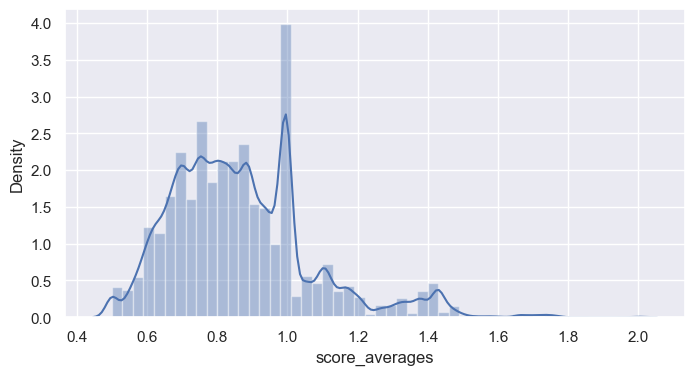

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np

sns.set(rc={"figure.figsize": (8, 4)}); np.random.seed(0)
ax = sns.distplot(df_tot['score_averages'])
plt.show()

In [13]:
m = score_counts.quantile(0.95)
m

2.0

In [14]:
qualified = df_tot[(df_tot['score'] >= m) & (df_tot['score'].notnull()) & (df_tot['score_averages'].notnull())][['userid', 'game', 'action', 'purchase_or_hours', 'score', 'score_averages']]
qualified['score'] = qualified['score'].astype('int')
qualified['score_averages'] = qualified['score_averages'].astype('int')
qualified.shape

(17183, 6)

In [15]:
qualified['score_averages'].mean()

0.46278298318105104

In [16]:
qualified

,userid,game,action,purchase_or_hours,score,score_averages
1,151603712,The Elder Scrolls V Skyrim,play,273.0,3,1
3,59945701,The Elder Scrolls V Skyrim,play,58.0,3,1
6,92107940,The Elder Scrolls V Skyrim,play,110.0,3,1
8,250006052,The Elder Scrolls V Skyrim,play,465.0,3,1
10,11373749,The Elder Scrolls V Skyrim,play,220.0,3,1
...,...,...,...,...,...,...
199742,246319849,NOBUNAGA'S AMBITION Kakushin with Power Up Kit,play,267.0,3,2
199744,74772820,Eschalon Book 1,play,57.0,3,2
199802,42380987,Wildlife Park 2,play,29.0,2,1
199920,213854339,Eastside Hockey Manager,play,1295.0,3,2


In [17]:
df_tot

,userid,game,action,purchase_or_hours,score,score_averages
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,1,1.376614
1,151603712,The Elder Scrolls V Skyrim,play,273.0,3,1.376614
2,59945701,The Elder Scrolls V Skyrim,purchase,1.0,1,1.376614
3,59945701,The Elder Scrolls V Skyrim,play,58.0,3,1.376614
4,53875128,The Elder Scrolls V Skyrim,purchase,1.0,1,1.376614
...,...,...,...,...,...,...
199995,135400225,Space Colony,play,12.0,0,0.500000
199996,135400225,Life is Hard,purchase,1.0,1,0.500000
199997,135400225,Life is Hard,play,3.1,0,0.500000
199998,135400225,Executive Assault,purchase,1.0,1,0.500000


In [18]:
df_tot.shape

(200000, 6)

17183 video games are considered on our chart, with an average score of 0.46. 

In [19]:
def weighted_rating(x):
    v = x['score']
    R = x['score_averages']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [20]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified

,userid,game,action,purchase_or_hours,score,score_averages,wr
1,151603712,The Elder Scrolls V Skyrim,play,273.0,3,1,0.928974
3,59945701,The Elder Scrolls V Skyrim,play,58.0,3,1,0.928974
6,92107940,The Elder Scrolls V Skyrim,play,110.0,3,1,0.928974
8,250006052,The Elder Scrolls V Skyrim,play,465.0,3,1,0.928974
10,11373749,The Elder Scrolls V Skyrim,play,220.0,3,1,0.928974
...,...,...,...,...,...,...,...
199742,246319849,NOBUNAGA'S AMBITION Kakushin with Power Up Kit,play,267.0,3,2,1.528974
199744,74772820,Eschalon Book 1,play,57.0,3,2,1.528974
199802,42380987,Wildlife Park 2,play,29.0,2,1,0.911218
199920,213854339,Eastside Hockey Manager,play,1295.0,3,2,1.528974


In [21]:
qualified.sort_values('wr', ascending=False).head(250)

Without rescaling the score index using the Weighted Rating transformation, we would not have been able to clearly discriminate between games with purchase_or_hours score greater than 50 e.g.Worldwide Soccer Manager 2009 and Call of Duty Modern Warfare 2 - Multiplayer.

But by taking into account the average score of each game, that is their overall rating by the userbase, we observe that Worldwide Soccer Manager 2009, FIFA Manager 11, 	Cultures - Northland, 	RPG Maker MV and Runers
are associated with the highest Weighted Rating scores, with only 823 cumulated hours played. 

On the contrary, the Call of Duty saga yields the smallest Weighted Rating scores, 0.92 on average, with almost 2400 hours played in total.

## Collaborative Filtering

In order to use the surprise scikit tool, one needs to extract some columns from 'qualified' and restrict the new dataframe to a specific structure:

user ; item ; rating ; timestamp (optional)

In [23]:
df_surprise = qualified[["userid", "game", "wr"]]
df_surprise.rename(columns = {'userid':'user', 'game':'item', 'wr': 'rating'}, inplace = True)

C:\Users\Charlotte\Anaconda3\lib\site-packages\pandas\core\frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
# Instiate the Reader object, belonging to the Reader class, in order to parse our datafile that containing ratings.
reader = Reader(line_format = 'user item rating', rating_scale=(1, 5))

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_surprise[['user', 'item', 'rating']], reader)

SVD Algorithm

In [25]:
cross_validate(SVD(), data, cv=2)

{'test_rmse': array([0.21573195, 0.15839607]),
 'test_mae': array([0.14037551, 0.10719983]),
 'fit_time': (0.016997098922729492, 0.0169980525970459),
 'test_time': (0.002004384994506836, 0.0010006427764892578)}

In [26]:
# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.1800
RMSE: 0.2065
RMSE: 0.1756


In [27]:
pd.DataFrame(predictions)

,uid,iid,r_ui,est,details
0,70778973,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
1,32847394,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
2,58794630,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
3,26122540,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
4,241862248,The Crew,0.928974,1.000000,{'was_impossible': False}
...,...,...,...,...,...
78,122492047,Pro Cycling Manager 2014,1.528974,1.056844,{'was_impossible': False}
79,83336644,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
80,32102983,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
81,81943620,Assassin's Creed IV Black Flag,0.928974,1.000000,{'was_impossible': False}


Grid-Searching

In [28]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.18630768540367426
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}


In [29]:
kf = KFold(n_splits=5)

algo_opti = SVD(n_epochs = 10, lr_all= 0.005, reg_all = 0.4)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo_opti.fit(trainset)
    predictions = algo_opti.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.2016
RMSE: 0.1454
RMSE: 0.2215
RMSE: 0.1904
RMSE: 0.1757


KNN Algorithm

In [33]:
KNN_baseline = surprise.prediction_algorithms.knns.KNNBaseline()
KNN_baseline.fit(trainset)

predictions_KNN = KNN_baseline.test(testset)
accuracy.rmse(predictions_KNN, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1669


0.1669277620954798

In [34]:
pd.DataFrame(predictions_KNN)

,uid,iid,r_ui,est,details
0,76027799,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
1,61772065,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
2,156818121,Assassin's Creed IV Black Flag,0.928974,1.000000,{'was_impossible': False}
3,53621752,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
4,82112070,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
5,59382844,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
6,36502549,Borderlands,0.928974,1.000000,{'was_impossible': False}
7,26122540,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
8,55498890,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
9,56470008,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}


In [35]:
PMF = surprise.prediction_algorithms.matrix_factorization.SVD()
PMF.fit(trainset)

predictions_PMF = PMF.test(testset)
accuracy.rmse(predictions_PMF, verbose=True)

RMSE: 0.1627


0.16269575582891935

In [38]:
pd.DataFrame(predictions_PMF)

,uid,iid,r_ui,est,details
0,76027799,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
1,61772065,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
2,156818121,Assassin's Creed IV Black Flag,0.928974,1.000000,{'was_impossible': False}
3,53621752,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
4,82112070,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
5,59382844,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
6,36502549,Borderlands,0.928974,1.000000,{'was_impossible': False}
7,26122540,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
8,55498890,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
9,56470008,Call of Duty Modern Warfare 2 - Multiplayer,0.928974,1.000000,{'was_impossible': False}
